In [ ]:
!pip install koolbox scikit-learn==1.5.2

In [1]:
# ========================================
# 케글 가상화폐 가격예측 앙상블 모델
# ========================================

# 필수 라이브러리 설치
# !pip install koolbox scikit-learn==1.5.2

# ========================================
# 1. 라이브러리 임포트
# ========================================
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
from lightgbm import LGBMRegressor
from scipy.stats import pearsonr as pr
from xgboost import XGBRegressor
from sklearn.base import clone
from koolbox import Trainer  # 커스텀 훈련 유틸리티
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import optuna  # 하이퍼파라미터 최적화
import joblib
import gc

warnings.filterwarnings("ignore")

/Users/sbk/portfolio/DRW-Crypto-Market-Prediction/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# ========================================
# 2. 설정 파라미터
# ========================================
class CFG:
    """실험 설정 클래스"""
    train_path = "../data/drw-crypto-market-prediction/train.parquet"
    test_path = "../data/drw-crypto-market-prediction/test.parquet"
    sample_sub_path = "../data/drw-crypto-market-prediction/sample_submission.csv"
    
    target = "label"  # 예측할 타겟 변수
    n_folds = 5  # 교차검증 폴드 수
    seed = 42  # 랜덤 시드
    
    run_optuna = True  # Optuna 하이퍼파라미터 최적화 실행 여부
    n_optuna_trials = 250  # Optuna 시행 횟수

In [3]:
# ========================================
# 3. 메모리 최적화 함수
# ========================================
def reduce_mem_usage(dataframe, dataset):    
    """데이터프레임의 메모리 사용량을 최적화하는 함수
    
    Args:
        dataframe: 최적화할 데이터프레임
        dataset: 데이터셋 이름 (로깅용)
    
    Returns:
        최적화된 데이터프레임
    """
    print('Reducing memory usage for:', dataset)
    initial_mem_usage = dataframe.memory_usage().sum() / 1024**2
    
    for col in dataframe.columns:
        col_type = dataframe[col].dtype
        c_min = dataframe[col].min()
        c_max = dataframe[col].max()
        
        # 정수형 데이터 타입 최적화
        if str(col_type)[:3] == 'int':
            if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                dataframe[col] = dataframe[col].astype(np.int8)
            elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                dataframe[col] = dataframe[col].astype(np.int16)
            elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                dataframe[col] = dataframe[col].astype(np.int32)
            elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                dataframe[col] = dataframe[col].astype(np.int64)
        # 실수형 데이터 타입 최적화
        else:
            if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                dataframe[col] = dataframe[col].astype(np.float16)
            elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                dataframe[col] = dataframe[col].astype(np.float32)
            else:
                dataframe[col] = dataframe[col].astype(np.float64)

    final_mem_usage = dataframe.memory_usage().sum() / 1024**2
    print('--- Memory usage before: {:.2f} MB'.format(initial_mem_usage))
    print('--- Memory usage after: {:.2f} MB'.format(final_mem_usage))
    print('--- Decreased memory usage by {:.1f}%\n'.format(100 * (initial_mem_usage - final_mem_usage) / initial_mem_usage))

    return dataframe

In [4]:
# ========================================
# 4. 피처 엔지니어링 함수
# ========================================
def add_features(df):
    """가상화폐 거래 데이터에서 금융 지표 피처들을 생성하는 함수
    
    Args:
        df: 원본 거래 데이터
    
    Returns:
        생성된 피처들을 포함한 데이터프레임
    """
    data = df.copy()
    features_df = pd.DataFrame(index=data.index)
    
    # === 호가창 관련 지표 ===
    features_df['bid_ask_spread_proxy'] = data['ask_qty'] - data['bid_qty']  # 매도-매수 호가 차이
    features_df['total_liquidity'] = data['bid_qty'] + data['ask_qty']  # 전체 유동성
    features_df['order_imbalance'] = (data['bid_qty'] - data['ask_qty']) / (data['bid_qty'] + data['ask_qty'] + 1e-8)  # 주문 불균형
    features_df['order_imbalance_abs'] = np.abs(features_df['order_imbalance'])  # 주문 불균형 절댓값
    
    # === 거래량 관련 지표 ===
    features_df['trade_imbalance'] = data['buy_qty'] - data['sell_qty']  # 매수-매도 거래량 차이
    features_df['total_trades'] = data['buy_qty'] + data['sell_qty']  # 총 거래량
    features_df['volume_per_trade'] = data['volume'] / (data['buy_qty'] + data['sell_qty'] + 1e-8)  # 거래당 평균 거래량
    
    # === 매수/매도 압력 지표 ===
    features_df['buying_pressure'] = data['buy_qty'] / (data['buy_qty'] + data['sell_qty'] + 1e-8)  # 매수 압력
    features_df['selling_pressure'] = data['sell_qty'] / (data['buy_qty'] + data['sell_qty'] + 1e-8)  # 매도 압력
    features_df['buy_volume_ratio'] = data['buy_qty'] / (data['volume'] + 1e-8)  # 매수 거래량 비율
    features_df['sell_volume_ratio'] = data['sell_qty'] / (data['volume'] + 1e-8)  # 매도 거래량 비율
    
    # === 유동성 관련 지표 ===
    features_df['bid_liquidity_ratio'] = data['bid_qty'] / (data['volume'] + 1e-8)  # 매수 호가 유동성 비율
    features_df['ask_liquidity_ratio'] = data['ask_qty'] / (data['volume'] + 1e-8)  # 매도 호가 유동성 비율
    features_df['volume_liquidity_ratio'] = data['volume'] / (data['bid_qty'] + data['ask_qty'] + 1e-8)  # 거래량 대비 유동성
    
    # === 비율 지표 ===
    features_df['buy_sell_ratio'] = data['buy_qty'] / (data['sell_qty'] + 1e-8)  # 매수/매도 비율
    features_df['bid_ask_ratio'] = data['bid_qty'] / (data['ask_qty'] + 1e-8)  # 매수호가/매도호가 비율
    
    # === 상호작용 지표 ===
    features_df['buy_volume_product'] = data['buy_qty'] * data['volume']  # 매수량과 거래량의 곱
    features_df['sell_volume_product'] = data['sell_qty'] * data['volume']  # 매도량과 거래량의 곱
    features_df['bid_ask_product'] = data['bid_qty'] * data['ask_qty']  # 호가량들의 곱
    
    # === 시장 경쟁도 지표 ===
    features_df['market_competition'] = (data['buy_qty'] * data['sell_qty']) / ((data['buy_qty'] + data['sell_qty']) + 1e-8)  # 시장 경쟁도
    features_df['liquidity_competition'] = (data['bid_qty'] * data['ask_qty']) / ((data['bid_qty'] + data['ask_qty']) + 1e-8)  # 유동성 경쟁도
    
    # === 시장 활동도 지표 ===
    total_activity = data['buy_qty'] + data['sell_qty'] + data['bid_qty'] + data['ask_qty']
    features_df['market_activity'] = total_activity  # 전체 시장 활동도
    features_df['activity_concentration'] = data['volume'] / (total_activity + 1e-8)  # 활동 집중도
    features_df['depth_imbalance'] = features_df['total_trades'] - data['volume']  # 깊이 불균형
    
    # === 정보 흐름 지표 ===
    features_df['info_arrival_rate'] = (data['buy_qty'] + data['sell_qty']) / (data['volume'] + 1e-8)  # 정보 도착률
    features_df['market_making_intensity'] = (data['bid_qty'] + data['ask_qty']) / (data['buy_qty'] + data['sell_qty'] + 1e-8)  # 마켓메이킹 강도
    features_df['effective_spread_proxy'] = np.abs(data['buy_qty'] - data['sell_qty']) / (data['volume'] + 1e-8)  # 유효 스프레드 근사치
    
    # === 시계열 지표 (지수가중이동평균) ===
    lambda_decay = 0.95  # 감쇠 계수
    ofi = data['buy_qty'] - data['sell_qty']  # Order Flow Imbalance
    features_df['order_flow_imbalance_ewm'] = ofi.ewm(alpha=1-lambda_decay).mean()  # OFI 지수가중이동평균

    # 무한값과 NaN 처리
    features_df = features_df.replace([np.inf, -np.inf], np.nan)
    
    return features_df

In [5]:
# ========================================
# 5. 제거할 특성 목록 (노이즈가 많은 특성들)
# ========================================
cols_to_drop = [
    'X697', 'X698', 'X699', 'X700', 'X701', 'X702', 'X703', 'X704', 'X705', 'X706', 
    'X707', 'X708', 'X709', 'X710', 'X711', 'X712', 'X713', 'X714', 'X715', 'X716',
    'X717', 'X864', 'X867', 'X869', 'X870', 'X871', 'X872', 'X104', 'X110', 'X116',
    'X122', 'X128', 'X134', 'X140', 'X146', 'X152', 'X158', 'X164', 'X170', 'X176',
    'X182', 'X351', 'X357', 'X363', 'X369', 'X375', 'X381', 'X387', 'X393', 'X399',
    'X405', 'X411', 'X417', 'X423', 'X429'
]

In [7]:
# ========================================
# 6. 데이터 로딩 및 전처리
# ========================================
print("데이터 로딩 중...")
train = pd.read_parquet(CFG.train_path).reset_index(drop=True)
test = pd.read_parquet(CFG.test_path).reset_index(drop=True)

# 메모리 최적화
train = reduce_mem_usage(train, "train")
test = reduce_mem_usage(test, "test")

# 특성과 타겟 분리
X = train.drop([CFG.target] + cols_to_drop, axis=1)
y = train[CFG.target]
X_test = test.drop([CFG.target] + cols_to_drop, axis=1)

Reducing memory usage for: train
--- Memory usage before: 3594.93 MB
--- Memory usage after: 961.92 MB
--- Decreased memory usage by 73.2%

Reducing memory usage for: test
--- Memory usage before: 3678.76 MB
--- Memory usage after: 984.36 MB
--- Decreased memory usage by 73.2%



In [8]:
print("피처 엔지니어링 진행 중...")
X = pd.concat([add_features(X), X], axis=1)
X_test = pd.concat([add_features(X_test), X_test], axis=1)

In [9]:
# ========================================
# 7. 평가 지표 함수
# ========================================
def pearsonr(y_true, y_pred):
    """피어슨 상관계수 계산 함수 (평가 지표)"""
    return pr(y_true, y_pred)[0]

In [12]:
# ========================================
# 8. 미리 튜닝된 하이퍼파라미터
# ========================================

# LightGBM (GBDT) 파라미터
lgbm_params = {
    "boosting_type": "gbdt",  # Gradient Boosting Decision Tree
    "colsample_bytree": 0.6668813654729736,  # 각 트리에서 사용할 피처 비율
    "learning_rate": 0.03388752361020876,  # 학습률
    "min_child_samples": 27,  # 리프 노드의 최소 샘플 수
    "min_child_weight": 0.8201187421311484,  # 리프 노드의 최소 가중치
    "n_estimators": 1877,  # 부스팅 라운드 수
    "n_jobs": -1,  # 병렬 처리
    "num_leaves": 9,  # 트리의 최대 리프 수
    "random_state": 42,
    "reg_alpha": 79.84499181826652,  # L1 정규화
    "reg_lambda": 49.39626011777799,  # L2 정규화
    "subsample": 0.2032810514888036,  # 서브샘플링 비율
    "verbose": -1
}

# LightGBM (GOSS) 파라미터
lgbm_goss_params = {
    "boosting_type": "goss",  # Gradient-based One-Side Sampling
    "colsample_bytree": 0.36556085663487903,
    "learning_rate": 0.008503127215485715,
    "min_child_samples": 23,
    "min_child_weight": 0.8163027430655353,
    "n_estimators": 601,
    "n_jobs": -1,
    "num_leaves": 68,
    "random_state": 42,
    "reg_alpha": 86.71523829378131,
    "reg_lambda": 9.227695570414218,
    "subsample": 0.4082026328069309,
    "verbose": -1
}

# XGBoost 파라미터
xgb_params = {
    "colsample_bylevel": 0.8640697224146584,  # 레벨별 피처 샘플링
    "colsample_bynode": 0.11087134395654064,  # 노드별 피처 샘플링
    "colsample_bytree": 0.4727045319253941,  # 트리별 피처 샘플링
    "gamma": 5.886793336088316,  # 최소 분할 손실
    "learning_rate": 0.014617031725894066,
    "max_depth": 17,  # 최대 트리 깊이
    "max_leaves": 21,  # 최대 리프 수
    "min_child_weight": 95,  # 자식 노드의 최소 가중치
    "n_estimators": 761,
    "n_jobs": -1,
    "random_state": 42,
    "reg_alpha": 58.33499071146719,
    "reg_lambda": 59.29921844166945,
    "subsample": 0.05819005276822031,
    "verbosity": 0
}

In [10]:
# ========================================
# 9. 모델 훈련 및 예측 저장소
# ========================================
fold_scores = {}  # 각 폴드별 점수
overall_scores = {}  # 전체 점수
oof_preds = {}  # Out-of-fold 예측값
test_preds = {}  # 테스트 예측값

In [13]:
# ========================================
# 10. LightGBM (GBDT) 훈련
# ========================================
print("LightGBM (GBDT) 모델 훈련 중...")
lgbm_trainer = Trainer(
    LGBMRegressor(**lgbm_params),
    cv=KFold(n_splits=5, shuffle=False),  # 5-폴드 교차검증
    metric=pearsonr,
    task="regression",
    metric_precision=6
)

lgbm_trainer.fit(X, y)

# 결과 저장
fold_scores["LightGBM (gbdt)"] = lgbm_trainer.fold_scores
overall_scores["LightGBM (gbdt)"] = [pearsonr(lgbm_trainer.oof_preds, y)]
oof_preds["LightGBM (gbdt)"] = lgbm_trainer.oof_preds
test_preds["LightGBM (gbdt)"] = lgbm_trainer.predict(X_test)

Training LGBMRegressor

--- Fold 0 - pearsonr: 0.153221 - Time: 108.88 s
--- Fold 1 - pearsonr: 0.094904 - Time: 106.93 s
--- Fold 2 - pearsonr: 0.061089 - Time: 107.27 s
--- Fold 3 - pearsonr: 0.123551 - Time: 113.03 s
--- Fold 4 - pearsonr: 0.090125 - Time: 106.07 s

------ Overall pearsonr: 0.097046 - Mean pearsonr: 0.104578 ± 0.031368 - Time: 542.53 s


In [14]:
# ========================================
# 11. LightGBM (GOSS) 훈련  
# ========================================
print("LightGBM (GOSS) 모델 훈련 중...")
lgbm_goss_trainer = Trainer(
    LGBMRegressor(**lgbm_goss_params),
    cv=KFold(n_splits=5, shuffle=False),
    metric=pearsonr,
    task="regression",
    metric_precision=6
)

lgbm_goss_trainer.fit(X, y)

fold_scores["LightGBM (goss)"] = lgbm_goss_trainer.fold_scores
overall_scores["LightGBM (goss)"] = [pearsonr(lgbm_goss_trainer.oof_preds, y)]
oof_preds["LightGBM (goss)"] = lgbm_goss_trainer.oof_preds
test_preds["LightGBM (goss)"] = lgbm_goss_trainer.predict(X_test)

Training LGBMRegressor

--- Fold 0 - pearsonr: 0.173826 - Time: 44.14 s
--- Fold 1 - pearsonr: 0.110349 - Time: 43.47 s
--- Fold 2 - pearsonr: 0.040952 - Time: 42.30 s
--- Fold 3 - pearsonr: 0.142582 - Time: 42.74 s
--- Fold 4 - pearsonr: 0.070511 - Time: 42.59 s

------ Overall pearsonr: 0.097135 - Mean pearsonr: 0.107644 ± 0.047822 - Time: 215.62 s


In [15]:
# ========================================
# 12. XGBoost 훈련
# ========================================
print("XGBoost 모델 훈련 중...")
xgb_trainer = Trainer(
    XGBRegressor(**xgb_params),
    cv=KFold(n_splits=5, shuffle=False),
    metric=pearsonr,
    task="regression",
    metric_precision=6
)

xgb_trainer.fit(X, y)

fold_scores["XGBoost"] = xgb_trainer.fold_scores
overall_scores["XGBoost"] = [pearsonr(xgb_trainer.oof_preds, y)]
oof_preds["XGBoost"] = xgb_trainer.oof_preds
test_preds["XGBoost"] = xgb_trainer.predict(X_test)

Training XGBRegressor

--- Fold 0 - pearsonr: 0.224836 - Time: 81.99 s
--- Fold 1 - pearsonr: 0.101503 - Time: 79.33 s
--- Fold 2 - pearsonr: 0.055131 - Time: 76.45 s
--- Fold 3 - pearsonr: 0.139252 - Time: 75.54 s
--- Fold 4 - pearsonr: 0.060086 - Time: 76.02 s

------ Overall pearsonr: 0.106530 - Mean pearsonr: 0.116162 ± 0.062334 - Time: 389.84 s


### Ensembling with Ridge

In [18]:
# 개별 모델의 예측값들을 새로운 특성으로 사용
X_ensemble = pd.DataFrame(oof_preds)
X_test_ensemble = pd.DataFrame(test_preds)

In [ ]:
# 예측값 저장 (추후 사용을 위해)
joblib.dump(X_ensemble, "oof_preds.pkl")
joblib.dump(X_test_ensemble, "test_preds.pkl")

['test_preds.pkl']

In [20]:
# ========================================
# 13. 앙상블을 위한 Ridge 회귀 하이퍼파라미터 최적화
# ========================================


def objective(trial):    
    """Optuna를 위한 목적 함수 - Ridge 회귀 하이퍼파라미터 최적화"""
    params = {
        "random_state": CFG.seed,
        "alpha": trial.suggest_float("alpha", 0, 100),  # L2 정규화 강도
        "tol": trial.suggest_float("tol", 1e-6, 1e-2),  # 수렴 허용오차
        "fit_intercept": trial.suggest_categorical("fit_intercept", [True, False]),  # 절편 추가 여부
        "positive": trial.suggest_categorical("positive", [True, False])  # 양수 제약 여부
    }

    trainer = Trainer(
        Ridge(**params),
        cv=KFold(n_splits=5, shuffle=False),
        metric=pearsonr,
        task="regression",
        verbose=False
    )
    trainer.fit(X_ensemble, y)
    
    return pearsonr(trainer.oof_preds, y)

# Optuna 최적화 실행
if CFG.run_optuna:
    print("Ridge 앙상블 하이퍼파라미터 최적화 중...")
    sampler = optuna.samplers.TPESampler(seed=CFG.seed, multivariate=True)
    study = optuna.create_study(direction="maximize", sampler=sampler)
    study.optimize(objective, n_trials=CFG.n_optuna_trials, n_jobs=-1, catch=(ValueError,))
    best_params = study.best_params

    ridge_params = {
        "random_state": CFG.seed,
        "alpha": best_params["alpha"],
        "tol": best_params["tol"],
        "fit_intercept": best_params["fit_intercept"],
        "positive": best_params["positive"]
    }
else:
    ridge_params = {"random_state": CFG.seed}

[I 2025-06-02 13:50:48,467] A new study created in memory with name: no-name-915feb0c-ea68-4c68-a1d4-b574e2eae22a
[I 2025-06-02 13:50:50,548] Trial 2 finished with value: 0.09395268153377374 and parameters: {'alpha': 41.7074601943809, 'tol': 0.009052721318856273, 'fit_intercept': False, 'positive': False}. Best is trial 2 with value: 0.09395268153377374.
[I 2025-06-02 13:50:50,558] Trial 1 finished with value: 0.09394535975321769 and parameters: {'alpha': 25.960437883270306, 'tol': 0.00021673711303438003, 'fit_intercept': False, 'positive': False}. Best is trial 2 with value: 0.09395268153377374.
[I 2025-06-02 13:50:50,653] Trial 11 finished with value: 0.08656365333732337 and parameters: {'alpha': 19.145747918061453, 'tol': 0.0017919642947965997, 'fit_intercept': True, 'positive': False}. Best is trial 2 with value: 0.09395268153377374.
[I 2025-06-02 13:50:50,694] Trial 5 finished with value: 0.0939467639679471 and parameters: {'alpha': 28.961393053809125, 'tol': 0.006428277822646461,

In [21]:
# ========================================
# 14. 최종 Ridge 앙상블 모델 훈련
# ========================================

print("최종 Ridge 앙상블 모델 훈련 중...")
ridge_trainer = Trainer(
    Ridge(**ridge_params),
    cv=KFold(n_splits=5, shuffle=False),
    metric=pearsonr,
    task="regression",
    metric_precision=6
)

ridge_trainer.fit(X_ensemble, y)

fold_scores["Ridge (ensemble)"] = ridge_trainer.fold_scores
overall_scores["Ridge (ensemble)"] = [pearsonr(ridge_trainer.oof_preds, y)]
ridge_test_preds = ridge_trainer.predict(X_test_ensemble)

Training Ridge

--- Fold 0 - pearsonr: 0.208031 - Time: 0.03 s
--- Fold 1 - pearsonr: 0.107466 - Time: 0.02 s
--- Fold 2 - pearsonr: 0.057464 - Time: 0.02 s
--- Fold 3 - pearsonr: 0.145347 - Time: 0.03 s
--- Fold 4 - pearsonr: 0.074459 - Time: 0.02 s

------ Overall pearsonr: 0.094846 - Mean pearsonr: 0.118553 ± 0.053895 - Time: 0.32 s


In [ ]:
# ========================================
# 15. 앙상블 가중치 시각화 함수
# ========================================
def plot_weights(weights, title):
    """앙상블 모델의 가중치를 시각화하는 함수"""
    sorted_indices = np.argsort(weights[0])[::-1]
    sorted_coeffs = np.array(weights[0])[sorted_indices]
    sorted_model_names = np.array(list(oof_preds.keys()))[sorted_indices]

    plt.figure(figsize=(10, weights.shape[1] * 0.5))
    ax = sns.barplot(x=sorted_coeffs, y=sorted_model_names, palette="RdYlGn_r")

    for i, (value, name) in enumerate(zip(sorted_coeffs, sorted_model_names)):
        if value >= 0:
            ax.text(value, i, f"{value:.3f}", va="center", ha="left", color="black")
        else:
            ax.text(value, i, f"{value:.3f}", va="center", ha="right", color="black")

    xlim = ax.get_xlim()
    ax.set_xlim(xlim[0] - 0.1 * abs(xlim[0]), xlim[1] + 0.1 * abs(xlim[1]))

    plt.title(title)
    plt.xlabel("")
    plt.ylabel("")
    plt.tight_layout()
    plt.show()

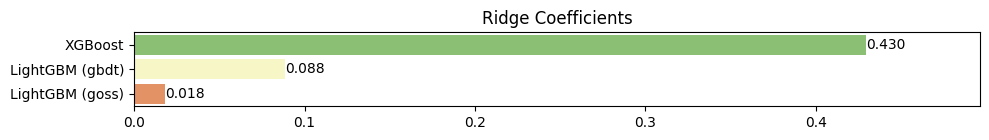

In [22]:
# 앙상블 가중치 계산 및 시각화
ridge_coeffs = np.zeros((1, X_ensemble.shape[1]))
for m in ridge_trainer.estimators:
    ridge_coeffs += m.coef_
ridge_coeffs = ridge_coeffs / len(ridge_trainer.estimators)

plot_weights(ridge_coeffs, "Ridge 앙상블 가중치")

In [ ]:
# ========================================
# 16. 최종 제출 파일 생성
# ========================================
print("최종 제출 파일 생성 중...")
sub = pd.read_csv(CFG.sample_sub_path)
sub["prediction"] = ridge_test_preds
sub.to_csv(f"submission_ridge_{overall_scores['Ridge (ensemble)'][0]:.6f}.csv", index=False)

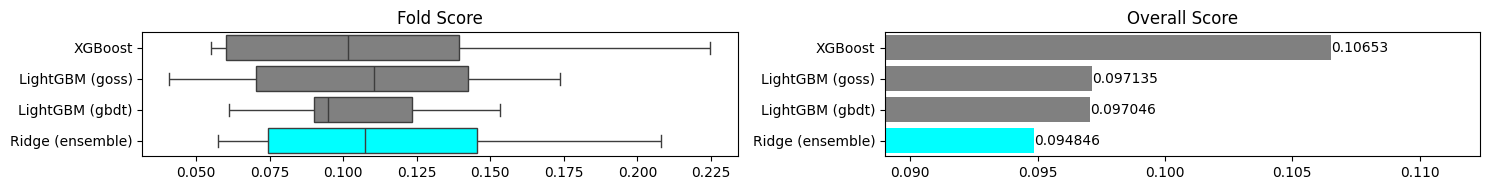

In [23]:
# ========================================
# 17. 결과 시각화
# ========================================
print("결과 시각화 생성 중...")
fold_scores_df = pd.DataFrame(fold_scores)
overall_scores_df = pd.DataFrame(overall_scores).transpose().sort_values(by=0, ascending=False)
order = overall_scores_df.index.tolist()

# 그래프 범위 설정
min_score = overall_scores_df.values.flatten().min()
max_score = overall_scores_df.values.flatten().max()
padding = (max_score - min_score) * 0.5
lower_limit = min_score - padding
upper_limit = max_score + padding

# 시각화
fig, axs = plt.subplots(1, 2, figsize=(15, fold_scores_df.shape[1] * 0.5))

# 폴드별 점수 박스플롯
boxplot = sns.boxplot(data=fold_scores_df, order=order, ax=axs[0], orient="h", color="grey")
axs[0].set_title("폴드별 점수 분포")
axs[0].set_xlabel("")
axs[0].set_ylabel("")

# 전체 점수 막대그래프
barplot = sns.barplot(x=overall_scores_df.values.flatten(), y=overall_scores_df.index, ax=axs[1], color="grey")
axs[1].set_title("전체 점수")
axs[1].set_xlabel("")
axs[1].set_xlim(left=lower_limit, right=upper_limit)
axs[1].set_ylabel("")

# 앙상블 모델 강조 표시
for i, (score, model) in enumerate(zip(overall_scores_df.values.flatten(), overall_scores_df.index)):
    color = "cyan" if "ensemble" in model.lower() else "grey"
    barplot.patches[i].set_facecolor(color)
    boxplot.patches[i].set_facecolor(color)
    barplot.text(score, i, round(score, 6), va="center")

plt.tight_layout()
plt.show()

print("✅ 모든 작업이 완료되었습니다!")
print(f"🏆 최고 성능: Ridge 앙상블 - {overall_scores['Ridge (ensemble)'][0]:.6f}") 